# Rivers Practical Part 1 - Extracting and analysing river networks

In this first part of the practical we will be generating a drainage network for the river Tay (shown below), in Scotland and performing some basic drainage analysis. 

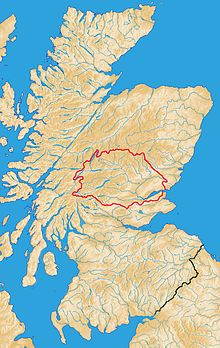

Much of this practical may seem 'boring' in that we are largely manipulating and pre-processing datasets before doing any 'proper' environmental analysis. This is by design as in reality 80 % of real-world data analysis will involve a significant amount of preprocessing. Much of the capabilities we will be using are also implemented in 'off-the-shelf' GIS software (e.g. QGIS if you are poor, or ArcGIS if you are rich!). However, nowadays they can also be performed using python packages which is a generally more powerful approach as it allows for interfacing with the rest of the python ecosystem (as well as being open-source, reproducible etc...). 

**Learning objectives**

At the end of this part of the practical you should be able to:
- Download and pre-process topographic data from a public source
- Generate drainage networks from a real DEM
- Perform basic analysis of drainage networks such as channel profile extraction

### Downloading topographic data

The first thing we need to do is get hold of topographic data for the area. The dataset we are going to be using is the global digital evelation model (DEM) produced by the [Shuttle Radar Topographic Mission](https://en.wikipedia.org/wiki/Shuttle_Radar_Topography_Mission) (SRTM). In particular we are going to be using the SRTM1s which provides surface height at, mostly, a resolution of 1 arcsecond. This is (at the equator) 30x30 metre squares. Due to the curvature of the Earth this resolution does change above 50 degrees of latitude (in this case) to 2 arc-second by 1 arc-second. More information about SRTMS can be found [here](https://www.usgs.gov/centers/eros/science/usgs-eros-archive-digital-elevation-shuttle-radar-topography-mission-srtm-1-arc?qt-science_center_objects=0#qt-science_center_objects).

The dataset is freely available and we will be using it for today's session. For convenience, the dataset is given in the format of 1x1 degree tiles. This makes it more practical to download for smaller areas but means we do need to identify which tiles we want, and then merge them together.   

***
#### **Tasks**

1. Create an account at the US Geological Survey's [EarthExplorer](https://earthexplorer.usgs.gov/) website, and **log-in**
2. Add in the following coordinates for the area which we which to investigate: (57N,5W),(57N,2W),(56N,2W),(56N,5W). Ignore all the other options for now. 
3. Navigate to the 'Data-sets' tab, and select 'Digital Elevation -> SRTM -> SRTM 1 Arc-Second Global'. Now, press the 'Results' at the bottom of the screen.
4. Select the 'footprint' button for each of the outputted results and identify the 3 'tiles' that makeup the entire area and download them in .tif format. 
6. Move these into the `data` subdirectory of this practical.  
***
### Merging the DEM tiles

We want to combine these three separate `.tif` (a geoTIFF) files into one continuous DEM of the region. For this we are going to use the `merge` capability that comes with GDAL, a set of libraries that provide essential spatial processing tools. You *should* have GDAL already installed on your system from previous practicals. However, if you are having major software issues with the following commands, let me know and we can help you.

The function we are going to use is `gdal_merge.py` which takes a list of infiles and then joins them together to produce one output raster map. We are going to call it from command line (using the `os.system` function which passes strings to command line and runs them). There is a python interface to GDAL but it is a little finnicky so we will just use the command line for now. 
***
#### **Tasks**

- In the following chunk, replace the square brackets with something sensible. Your outfile might be called something like `merged.tif` and your infiles you will need to give sequentially e.g. "file1.tif file2.tif". **HINT**: Consider using the 'wildcard' symbol, `*`... 
- When you run the chunk, if all goes well you should see a '0' outputted. Check your command prompt for full outputs. 
- Check that your outfile has been generated in the location that you told it to be. 
***

In [ ]:
import os
# os.system("gdal_merge.py -o [your_outfile_name_here] [infiles]")

### Projecting the data 

Now that we have combined the tiles we need to _project_ them onto a flat surface. For this we use the inestimably useful [gdalwarp](https://gdal.org/programs/gdalwarp.html) function. This command line tool takes raster data and projects it between coordinate reference systems. 

There are a number of ways to tell gdalwarp what to project it to but a common way is to use a ['PROJ' string.](https://proj.org/usage/quickstart.html). See the following link for further details if interested but it is essentially just a common format for presenting the relevant parameters required to uniquely describe a particular projection. In this instance we are going to use a **cylindrical equal area** (c.e.a) projection with the 45 degree of latitude as the standard parallel (also known as Gall-Peters projection) and using the WGS84 ellipse, projecting it to metres. 

The proj string we are using as a result is: `+proj=cea +lon_0=0 +lat_ts=45 +x_0=0 +y_0=0 +ellps=WGS84 +units=m +no_defs`. 
***
#### **Questions/Tasks**
- Why is it better for this practical to have an equal-area projection than a conformable (equal-angle) projection? 
- What does the argument '+ellps=WGS84' signify
- Convince yourself you're happy with what the other arguments in the proj string are doing.
***

**NB** in this case `gdal` works out what the coordinate system of the input file is because it is stored in the metadata of the geoTIFF. This is not always the case and for those cases we need to also tell it the projection information about the input file too, which is done in a similar way to the target reference system. 

Now we use this proj string to project the merged DEM. The following arguments are used (although there many others)

`-t_srs`: Target coordinate system defined by the `proj` string. 

`-tr`: Target resolution. This is the output resolution of the raster grid, given as 200x200 metres squares.

`-of`: Output filetype. We want to save it as netCDF as this is easier for our subsequent package to load in.
***
#### **Tasks** 
- Replace the square brackets in the following command with sensible file names (**hint**: we're saving it as a netCDF) 
- Confirm to yourself that you're happy with what each argument in the following chunk does 
- If successful the following chunk should output '0'. 
***

In [ ]:
# os.system("gdalwarp -t_srs '+proj=cea +lon_0=0 +lat_ts=45 +x_0=0 +y_0=0 +ellps=WGS84 +units=m +no_defs' -tr 200 200 -of netCDF [input_file_name] [output_file_name]")

Now, you should have a topographic raster grid as a netCDF file with a resolution of 200x200 metres. Equipped with this, we are going to start analysing the drainage of the region.

## LandLab

`LandLab` is ['a python toolkit for modeling earth surface processes'](https://landlab.github.io/#/). It provides open-source and (mostly) user-friendly functionality to wide-range of surface-process related tools. In this practical we are largely going to be focussing on the components related to directing and accumulating flow but there is a wide-range of other components with the package. The basic data-structure of `LandLab` is the 'model-grid' which defines the basis for modelling a landscape. We are focussing on the simple case of a raster grid (panel a) whereby each cell is rectangular. Other more complex grids are supported. In a model grid, each node can hold information about some parameters, such as topographic elevation, which is stored as a 'field'. Standard operations (e.g. flow-routing) can then be performed upon them. Full details about `LandLab` and its philosophy is given in [Hobley et al. (2017)](https://esurf.copernicus.org/articles/5/21/2017/esurf-5-21-2017.html). Each node in the field is given a unique ID, which starts at 0 at the lower left and increases up to N-1 where N is the total number of nodes. The indexing is _exactly the same as used in Numpy_


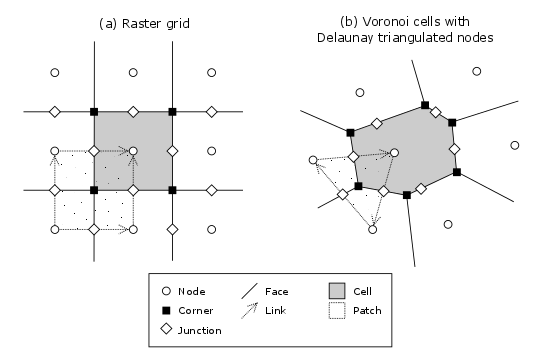

### Loading in the data

LandLab's default input/output functions are not the best so we're going to use the generic `netCDF4` python library to load this data in. You should have some familiarity with netCDF's previously in other practicals, so this is left as an exercise.  

***
#### **Tasks**
- Use the netCDF package to load in the topographic grid netCDF file as a _2D numpy array_ (NOT a netCDF object)
- **hint**: you will need to identify the name of the variable which the topography is stored in with the netCDF.
- Store the topography array in a variable called 'topo_data'. 
***

In [ ]:
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import landlab

### Your code here
### 
###
###
### topo_data = ???

Now we are going to initiate a LandLab model-grid.
***
### **Tasks** 
- Using the `landlab.RasterModelGrid()` function, initiate a model grid and store it in a variable called `mg`. This function requires a shape tuple to be provided, e.g. (x,y), using the `xy_spacing` argument.
- Using the `mg.add_field()` function, add your topographic array to the field, and store it in a field called `topographic__elevation`. **hint** you will need to _flatten_ this array to 1D first. 
- You might find it helpful to look at the documentation using `?landlab.RasterModelGrid` and `?landlab.RasterModelGrid.add_field`.
***



In [ ]:
from landlab import RasterModelGrid

# ?RasterModelGrid
# ?RasterModelGrid.add_field

### Your code here 
###
###
###

If you have performed the above successfully, the next chunk should produce a topographic map displaying the topography of the region as well as the coastline in grey.

In [ ]:
from landlab import imshow_grid

topo_palette = plt.cm.cubehelix
topo_palette.set_under('grey')
plt.figure(figsize=(15,5))
landlab.imshow_grid(mg,'topographic__elevation',cmap=topo_palette,vmin=1)
plt.show()

### Flow-routing 

Having expertly generated a digital representation of our study region we can begin to analyse the drainage network of the region. 

The first step is to 'fill' the sinks in the topography. Natural DEMs will always contain little pits and holes. These may be 'real' such as lakes, ponds etc... but also will be artificial introduced by measurement errors in the DEM. If these are not dealt with, any drainage calculated will be unrealistic, stopping at every minor pit in the landscape. Instead, we want to force everything here to drain to the oceans. We do this by filling in pits in the topography. 

To perform this sink filling step we use the algorithm developed by Richard Barnes at Berkeley (see [Barnes et al. 2014](https://dx.doi.org/10.1016/j.cageo.2013.04.024) for details). In landlab this is implemented using the [`SinkFillerBarnes` component.](https://landlab.readthedocs.io/en/master/reference/components/sink_fill.html)

***
### **Tasks** 
- Instantiate a "Sink Filler" component using the `SinkFillerBarnes`. We want to point it towards our `topographic__elevation` grid, and use the `D8` method for flow-routing. Set `fill_flat` to `False` and `ignore_overfill` to `True`.  
- Use the `run_one_step()` function ofthe `SinkFillerBarnes` object to actually fill the depressions (This can be slow!)
***


In [ ]:
from landlab.components import SinkFillerBarnes
# ?SinkFillerBarnes
### Your code here
###
###

The sink-filler has now _modified_ our `topographic__elevation` DEM so that drainage flows correctly across it. Given that this is changing our data it's important to work out where our DEM has been changed, by how much, and why. 

***
### **Tasks** 
- By comparing the original 'raw' DEM data we loaded in, to the data stored in the `topographic__elevation` field calculate the maximum change that the sink filling has generated. 
- Make a 'difference-map' between the original and modified datasets. Where are the biggest changes? What real-life features do you think these are likely to be? (Have a look at the map of the Basin at the very top of this practical...)
- **HINTS**: Use `RasterModelGrid.at_node['topographic__elevation']`  to extract the topographic data. If you use `plt.imshow` to generate your difference map, note that `MatPlotLib` puts the origin at the top-left not the bottom-left. This can be changed with the `origin` argument.  
***

In [ ]:
### Your code here 
###
###
###

### Flow-routing

Now the topography is loaded in and processed we can (finally) calculate the drainage over the topography. The way we're going to do this is by using the D8 flow-routing algorithm. We discussed this in the lecture but a quick recap now. This algorithm assumes that for a cell in a DEM, flow can only go in **one** of **eight** directions (hence D**8**). The way the algorithm works is that it cycles through every cell and then calculates in which of these 8 directions (N,NE,E,SE etc..) the slope is steepest. Then, it declares that the node which that direction points to is the 'receiver node' for the flow. The cell that the flow originated from is called the 'donor cell'. Once the flow-direction for every cell is known, it is possible to simply loop through the entire drainage network following the flow directions, adding up the accumulated flow.


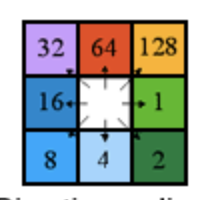

In LandLab, flow accumulation is performed using the `FlowAccumulator` component. This works in the same way as the `SinkFillerBarnes` component.
***
### **Tasks** 
- Instantiate an instance of a `FlowAccumulatorObject` and assign it to an appropriately named variable. You will have to provide it with: a model grid, the name of the topographic field, and the flowrouting we want to use, in this case `FlowDirectorD8`.
- Call the FlowAccumualtor object's `run_one_step` function to route drainage across the drainage area. Calling this will generate a number of new field's within the model grid. 
***


In [ ]:
### Your code here 
#
# 
#

If the above has been performed correctly the chunk below should produce a map of the drainage area in the region, with coastlines. 

In [ ]:
plt.figure(figsize=(25,7.5))
palette = plt.cm.viridis
palette.set_under('grey')

# Set ocean to some negative value
drainage_area_coast = np.copy(mg.at_node['drainage_area'])
drainage_area_coast[topo_data.flatten()==0] = -999

mg.add_field('drainage_area_coast',drainage_area_coast,clobber=True)
imshow_grid(mg,'drainage_area_coast',cmap=palette,vmin=0,var_name="Drainage Area/m2")
plt.show()

The above figure is a little bit tricky to visualise because only the very largest upstream area is visible. One solution is to use the drainage area information we have to make a map of where we think there are likely to be river channels. A very simple way to do that is to simply specify a threshold drainage area above which we are saying that the model cell is likely the be a channel. 

***
### **Tasks** 
- By extracting `drainage_area` from the model grid, generate a `boolean` array (called 'channels') which indicates where the drainage is greater than 25 km$^2$.
- Add this as a field on the model grid also called `channels`. 
***


In [ ]:
### Your code here 
###
###
###

If you performed the above correctly the following chunk should generate a map of the location of major river channels in the region. The channels should show up as '1' and cells not deemed to be channels should be '0'. Ocean areas should come up grey. 

In [ ]:
# This chunk is a little involved and is just a 'hacky' way to try and get 
# coastlines to plot on the figure. Look but don't touch (unless you really want to then by all means go ahead)!

plt.figure(figsize=(25,7.5))
palette = plt.cm.magma
palette.set_under('grey')
channels_coast = np.copy(mg.at_node['channels']).astype(float)
channels_coast[topo_data.flatten()==0] = -999

mg.add_field('channels_coast',channels_coast,clobber=True)
 # Set ocean to some negative value
imshow_grid(mg,'channels_coast',cmap=palette,vmin=0)

Well done! You have successfully generated a synthetic model of the drainage network for our study region, using just raw topographic data. 

***
### **Questions**
- How could we independently verify if this drainage network is accurate? 
- Have a look at the modelled drainage at ~130km East and 50km North. What might be causing these features?
***


## Analysing the River Tay

Having extracted drainage from the area we now want to perform some basic geomorphic/hydrological analysis on the River Tay, the largest river in this region. 

What we want to do is explore how both elevation and upstream area change with downstream distance. To do this we are going to generate stream profiles. These are essentially cross-sections across fields but parallel to the path of a stream. LandLab has built-in functionalities to extract the points on a grid which lie on a stream, which we will be using. But first, we need to identify what river we want to analyse. To do this we need to identify the 'outlet node' for our drainage catchment of interest. This is the node on the model-grid to which all over nodes, eventually, donate their flow to. This should be at the mouth of the river. 

LandLab has a tool `get_watershed_outlet` which takes the node ID of any node in the model grid, and returns the node ID of the most downstream node. 

***
## **Tasks**
- Use the `RasterModelGrid.find_nearest_node((x,y))` function to find the node ID of some point within the Tay catchment
- Using this node ID and the `get_watershed_outlet` function find the node ID of the outlet of the Tay
- Then, use the `RasterModelGrid.xy_of_node` function to calculate the xy-coordinates of your modelled outlet. 
- Check that this makes sense by comparing this location to the Drainage map above.  
***

In [ ]:
from landlab.utils import get_watershed_outlet 

# node_ID_in_catchment = ? 
# node_ID_outlet = ? 
# xy_of_outlet = ?
# print(xy_of_outlet)

Now that we have got the ID of the Tay outlet we can now use the `ChannelProfiler` function in LandLab to extract the node ID's along the path of the Tay. Note that in this case we are only selecting the _longest_ channel of the catchment. The following chunk demonstrates how we set up and then generate a `ChannelProfiler` object in LandLab:

In [ ]:
from landlab.components import ChannelProfiler

profiler = ChannelProfiler(mg, main_channel_only=True, outlet_nodes=[node_ID_outlet]) # Initiate profiler
profiler.run_one_step() # Run profiler to populate the data structure.

Now that we have generated an interface to data along a river profile your final tasks are to produce river long profiles of both *elevation* and *upstream area*. Additionally we want you to generate a map of the topography, with the location of where the channel profile lies overlain on top. The tricky bits are done for you. These figures should be of publishable quality (labelled axes, titles, visible etc...)

***
## **Tasks** 

- Using the `mg.at_node` function, extract as 1D arrays both elevation and drainage area along the river profile **HINT**: The data-structure of `ChannelProfiler` objects are a little counterintuiive so I have already provided you with a list of the ID's of nodes along the river profile, as well as the distance of each node from the headwaters.  
- On **the same figure** but different y-axes plot upstream area and elevation as a function of distance downstream. Label the axes. 
- Below, you have been provided with a snippet (copied from above) that plots the topography of the region. Add the location of the extracted river channel to this figure using `plt.plot`. **HINT** use the the `RasterModelGrid.xy_at_node` function. 

***


In [ ]:
profile_ids = list(profiler.data_structure[node_ID_outlet].values())[0]["ids"] # Node IDs
profile_distances = list(profiler.data_structure[node_ID_outlet].values())[0]["distances"] # Distance of each channel node from head


#### Your code here 
####
####
####
#### 

plt.figure(figsize=(15,5))
landlab.imshow_grid(mg,'topographic__elevation',cmap=topo_palette,vmin=1)
### Add your code to plot the location of the channel profile below this line! 





plt.show()

***
## **Questions** 

- What causes the sudden 'jumps' in drainage area when plotted against distance?
- Does our river elevation profile look to be in tectonic equilibrium?
***

Congratulations! You now have an understanding for how to extract data along a river, theoretically, anywhere in the world. Whilst the analysis we have done here is extremely cursory, they now allow you to integrate drainage networks with other analyses in python. Moreover you now have first hand experience of how accessible datasets such as Hydrosheds are generated, albeit with a greater focus on quality control. 

***
## **Bonus Task** 

- [Hack's law](https://en.wikipedia.org/wiki/Hack%27s_law) predicts that the upstream area of a basin (A) scales with the longest stream length (L) within that basin according to: $L = C A^h$. 
- Using the techniques above to extract stream length and upstream area, find more data points so that you can calculate $C$ and $h$ for this region. 
- Make a power law plot of $L$ against $A$ (both x and y axes should be logarithmic) with your line of best fit added.
- $h$ typically is ~0.5, does your data fit with this? 
***

# Rivers Practical Part 2 - Tracking pollutants in the River Tay

The year is 2022, you have graduated from your MSci and it is your first day working as an environmental data analyst for the Department for Investigation, Research and Technology (DIRT, for short). 

Your manager hands you your first task. A group of Scottish activists from the Society for Protection of Environments with Water (SPEW) are claiming that the estuary of the River Tay has become polluted by heavy metals in recent years, and this is adversely affecting the population of the extremely endangered Tay Estuary River Dolphin. As evidence they have sent you a spreadsheet (`dolphins.csv`) which records the results from periodic population counts of dolphins in the Estuary. Your first task is to investigate whether these activists are correct. 

You recall that you have **sedimentary core** from the mouth of the Tay. The core is 2m long and the geochemistry was determined by analysing it using a [core-scanning device](https://boscorf.org/instruments/itrax-high-resolution-xrf-analysis-sediment-cores). This data are found in `core_chemistry.dat`. 

***
### **Tasks** 
1. Using these datasets, investigate whether you think the activists are right that pollution is affecting dolphin populations (assume a sedimentation rate of 1.5 cm/yr). **HINT**: Consider the distribution of your data.
***

In [ ]:
### Your code here
#
#
#


You are shocked by your results and decide to investigate further. A number of **mines** were built in the surrounding onshore region in 2010. You suspect that one of these might be the source of the metal pollution, as mined material could be entering the river network, polluting the estuary downstream. What metal do you think the mines are likely producing? 

7 mines were built, and the locations of them are given in `mines.dat`.

*** 
## **Tasks**
- Two of the mines can be immediately ruled out as the source of the pollution. 
- Using the skills you learned above work out which ones *can't* be polluting the Tay. **HINT** `landlab.utils.get_watershed_mask` may be helpful.
***

In [ ]:
### Your code here
# 
#
#

Whilst you can rule out two of the mines, there are still more than one possible sources of the pollution. As a result, you go out and gather samples of river sediment from the river along the main channel that you analysed above to help pinpoint the source of the pollution. You then measure them for the concentration of your proposed pollutant, lead.

***

### **Tasks**
- Using your drainage map of the River Tay, and this new geochemical data, can you rule out any more samples? 
***

In [ ]:
### Your code here 
# 
#
#
#

Whilst some further sources have now been ruled out, you decide you still need more data to fully locate the source of Pb. However, your manager says you only have enough money to gather **one** more river sediment samples. 

***
### **Tasks**
- Suggest  where it would be sensible to gather this final sample from.
***

This data is gathered and is found in `more_data.csv`.

***
### **Tasks**
- Reproduce your figure above but now include this data too. **HINT** You may find it helpful to use a log scale
- Which mine is the most likely source of the sediment
***

In [ ]:
### Your code here 
#
#
#

Having identified the likely culprit you resolve to work out the **rate at which lead is being released by the mine in kg/yr**

***
### **Tasks**
- How might you go about this? Think first about how you would calculate the _natural_ amount of lead in a river sediment. *If you are really stuck ask for some assistance*
- Treating each sample locality separately, calculate the likely amount of lead that has been added to the river by the mine (Assume an erosion rate of 1mm/yr, and a rock density of 2700 kg/m3, and that the total sediment flux is unchanged). 
- What assumptions are we making here?
***


In [ ]:
### Your code here 
# 
#
#

Presented with your results, the legal team of the mine claim that they aren't the source of the pollution at all. They claim that the river is simply naturally high in Lead at this location. You have just found enough money to analyse one more sediment sample for heavy metals.

***
### **Tasks**
- Where should you gather your one final sample from to definitely prove the mine is the source of the pollution?
- If you are correct and the mine is the source of the pollution, what should the Pb concentration of that sample be?
***


In [ ]:
# Your answer here

You gather this final sample and it has the exact concentration you predicted! The legal defense of the mine collapses and they are forced to close down. Lead pollution in the River Tay immediately ceases and the population of dolphins recovers, all thanks to your expert knowledge of how river networks operate.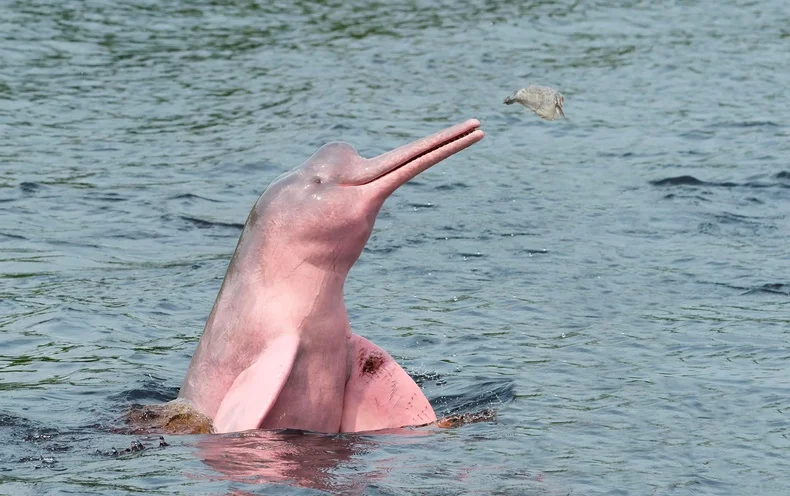

## Post-script 

This is obviously an extremely simplified scenario but similar situations do occur where upstream pollutants are transported downstream by rivers. An example which this practical is very loosely based on is the collapse of the dams which hold mining tailings. When these fail, large amounts of often toxic sediment is released into the river and transported downstream. Recently, in 2015, the [Fundao tailings dam in Brazil collapsed](https://en.wikipedia.org/wiki/Mariana_dam_disaster) releasing large amounts of sediment into the Doce river which eventually flowed out into the Atlantic, having an adverse affect on marine life (see below images). Before it could do this however the pollutant had to travel 100s of kms downstream to the sea. This type of pollutant transport is only possibly to understand and model with a solid framework of how drainage networks integrate upstream signals. 


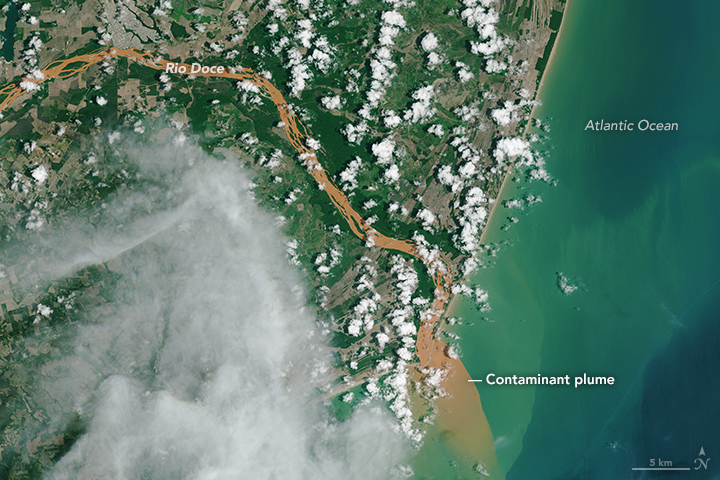
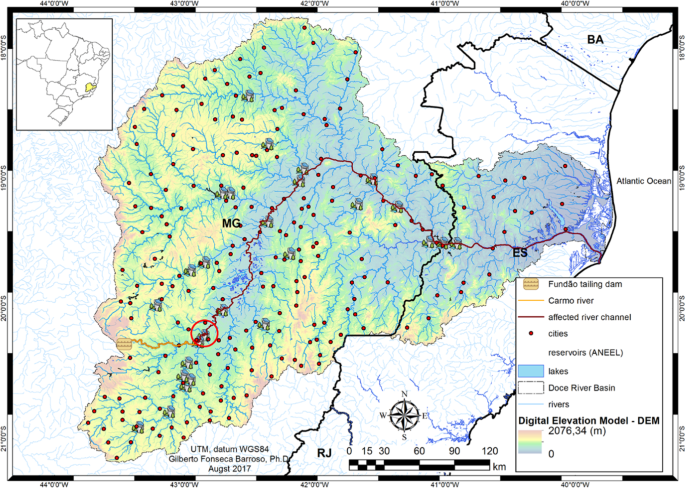